In [1]:
# Load libraries
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.interpolate

# For Gaussian process
#from sklearn.externals import joblib
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process import kernels
from sklearn.preprocessing import StandardScaler



In [2]:
################################# 
######## Define the model ######
#################################

# Return observable given parameter
def observable_1(x):
    
    result=x*x                   #<=========================================================
    
    return result

# Define the allowed range of values of the parameter x
xmin=0;                         #<=========================================================
xmax=10;                        #<=========================================================

In [3]:
#########################
#### Get the "data" #####
#########################

# Value of the parameter "x" we want to constrain with the Bayesian analysis
x_truth=3.6;                   #<=========================================================

# This will be a "closure test": we use the model to generate "data"
# The Bayesian parameter estimation should be peaked around "x_truth"
data_mean=observable_1(x_truth)

# Real data come with uncertainties
# Here, we just define an arbitrary uncertainty on the "data"
relative_uncertainty=.1      #<=========================================================
data_uncert=relative_uncertainty*data_mean

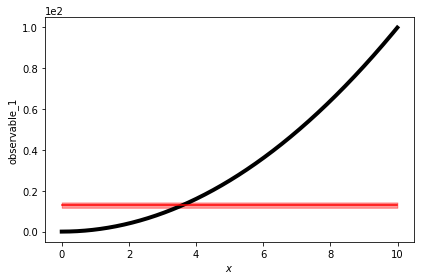

In [4]:
#########################
#### Plot the "data" #####
#########################

# Plot what the observable looks like over the parameter prior
plt.figure()
plt.xscale('linear')
plt.yscale('linear')
plt.xlabel(r'$x$')
plt.ylabel(r'observable_1')

# Compute the posterior for a range of values of the parameter "x"
x_range=np.arange(xmin, xmax, (xmax-xmin)/1000.)
y_list = [ observable_1(x) for x in x_range ]

# Plot the posterior
plt.plot(x_range, y_list, "-", color='black', lw=4)

plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

# Plot the true value of the parameter "x", for comparison
# plt.axvline(x=x_truth,color='red')

# Plot the "data"
plt.plot(x_range, np.full_like(x_range, data_mean), color='red')
plt.fill_between(x_range, data_mean-data_uncert, data_mean+data_uncert, color='red',alpha=.4)

plt.tight_layout()
plt.show()

In [5]:
########################
# Get the calculations #
########################

# Number of points used for the emulator
number_design_emulator=10                     #<=========================================================

# For simplicity, we sample the emulator uniformly
x_list=np.linspace(xmin,xmax,num=number_design_emulator)    #<===========================================

calculation_mean_list=observable_1(x_list)

# Model calculations typically have some uncertainties as well
####################################################################
# The Gaussian process library that we use (sklearn) cannot handle #
# different uncorrelated uncertainties across the parameter space  #
# (such as "relative uncertainties"                                #
####################################################################
relative_uncertainty=10.0               #<=========================================================
calculation_uncert_list=np.full_like(calculation_mean_list,relative_uncertainty)
# Add noise to calculations and let the hyperparameters be tuned to guess this noise
# (there has to be a better way of doing this! this is so silly)
calculation_mean_plus_noise=calculation_mean_list+np.random.normal(0,relative_uncertainty,size=len(calculation_mean_list))

RBF:  69.8**2 * RBF(length_scale=6.69)
White:  1.61**2 * WhiteKernel(noise_level=26.8)


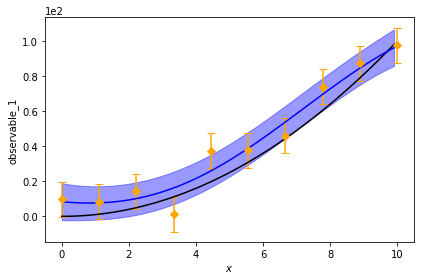

In [6]:
#########################################
# Make emulator for each observable #
#########################################

# See https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html for an example

parameter_space_length = xmax-xmin

# Kernels
k0 = 1. * kernels.RBF(
    length_scale=parameter_space_length/2.,
    length_scale_bounds=(2*parameter_space_length/number_design_emulator, parameter_space_length),
)


k2 = 1. * kernels.WhiteKernel(
    noise_level=relative_uncertainty,
    #noise_level_bounds='fixed'
    noise_level_bounds=(relative_uncertainty/2.,3*relative_uncertainty)
)

kernel = (k0+k2)

nrestarts=10

emulator_x_input=np.transpose([x_list])
emulator_y_input=calculation_mean_plus_noise

emulator_y_input_transform=emulator_y_input


# Fit a GP (optimize the kernel hyperparameters) to each PC.
gaussian_process=GPR(
    kernel=kernel,
    alpha=0.0001,
    n_restarts_optimizer=nrestarts,
    copy_X_train=True
    ).fit(emulator_x_input,emulator_y_input_transform)
     
# https://github.com/keweiyao/JETSCAPE2020-TRENTO-BAYES/blob/master/trento-bayes.ipynb
print('RBF: ', gaussian_process.kernel_.get_params()['k1'])
print('White: ', gaussian_process.kernel_.get_params()['k2'])


#####################
# Plot the emulator #
#####################

plt.figure()
plt.xscale('linear')
plt.yscale('linear')
plt.xlabel(r'$x$')
plt.ylabel(r'observable_1')

# Compute the posterior for a range of values of the parameter "x"
x_range=np.arange(xmin, xmax, (xmax-xmin)/100.)
y_list,y_list_uncert = gaussian_process.predict(np.transpose([x_range]), return_std=True)

# Plot design points
plt.errorbar(x_list, calculation_mean_plus_noise, yerr=calculation_uncert_list, fmt='D', color='orange',capsize=4)

# Plot the truth
plt.plot(x_range, observable_1(x_range), "-", color='black')

# Plot interpolator
plt.plot(x_range, y_list, color='blue')
plt.fill_between(x_range, y_list-y_list_uncert, y_list+y_list_uncert, color='blue',alpha=.4)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))


plt.tight_layout()
plt.show()

In [7]:
#########################
# Compute the posterior #
#########################

# We assume uniform priors for this example
# Here 'x' is the only model parameter
def prior(x):
    
    return 1


# Under the approximations that we're using, the likelihood is
# exp(-1/2*\sum_{observables, pT} (model(observable,pT)-data(observable,pT))^2/(model_err(observable,pT)^2+exp_err(observable,pT)^2)

# Here 'x' is the only model parameter
def likelihood(x):

    res=0.0

    #tmp_model_mean=emulator_calc(x)
    #tmp_model_uncert=emulator_uncert(x)
    
    tmp_model_mean, tmp_model_uncert=gaussian_process.predict(np.transpose([[x]]), return_std=True)

    tmp_data_mean=data_mean
    tmp_data_uncert=data_uncert
    
    cov=(tmp_model_uncert*tmp_model_uncert+tmp_data_uncert*tmp_data_uncert)

    res+=np.power(tmp_model_mean-tmp_data_mean,2)/cov

    res*=-0.5

    return np.exp(res)/np.sqrt(cov)

#
def posterior(x):
    
    return prior(x)*likelihood(x)

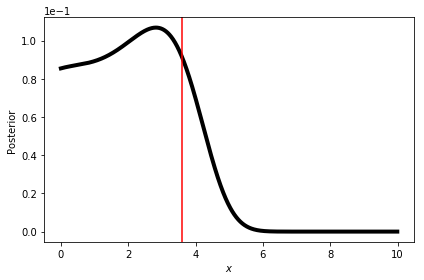

In [8]:
##################
# Plot posterior #
##################

plt.figure()
plt.xscale('linear')
plt.yscale('linear')
#plt.xlim(0,2)
#plt.ylim(1e-5,1e2)
plt.xlabel(r'$x$')
plt.ylabel(r'Posterior')

# Compute the posterior for a range of values of the parameter "x"
x_range=np.arange(xmin, xmax, (xmax-xmin)/1000.)
posterior_list = [ posterior(x) for x in x_range ]

# Plot the posterior
plt.plot(x_range, posterior_list, "-", color='black', lw=4)

plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

# Plot the true value, for comparison
plt.axvline(x=x_truth,color='red')

#plt.legend(loc='upper right',fontsize=16)
plt.tight_layout()
plt.show()